In [ ]:
from google.colab import files

files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d sachinpatel21/az-handwritten-alphabets-in-csv-format

Dataset URL: https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format
License(s): CC0-1.0
 88% 162M/185M [00:00<00:00, 210MB/s]
100% 185M/185M [00:00<00:00, 197MB/s]


In [ ]:
!unzip az-handwritten-alphabets-in-csv-format.zip

Archive:  az-handwritten-alphabets-in-csv-format.zip
  inflating: A_Z Handwritten Data.csv  
  inflating: A_Z Handwritten Data/A_Z Handwritten Data.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os


import seaborn as sns
from IPython.core.pylabtools import figsize

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,log_loss, classification_report, f1_score, accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.svm import SVC

# Read Data

In [ ]:
myDataFrame = pd.read_csv('A_Z Handwritten Data.csv')

# Identify the number of unique classes and show their distribution.

In [ ]:
dataLabels = myDataFrame.iloc[:,0]
numberOfDataClasses = len(dataLabels.unique())
classDistribution = dataLabels.value_counts()
classDistribution.index.name = None
print(f"Unique Classes Count => {numberOfDataClasses}")
print("=====================================================")
(classDistribution)

Unique Classes Count => 26


,count
14,57825
18,48419
20,29008
2,23409
19,22495
15,19341
13,19010
0,13869
12,12336
11,11586


# Normalize each image.

In [ ]:
images = myDataFrame.iloc[:,1:]
normalizedImages = images / 255.0

# Display one image from each class

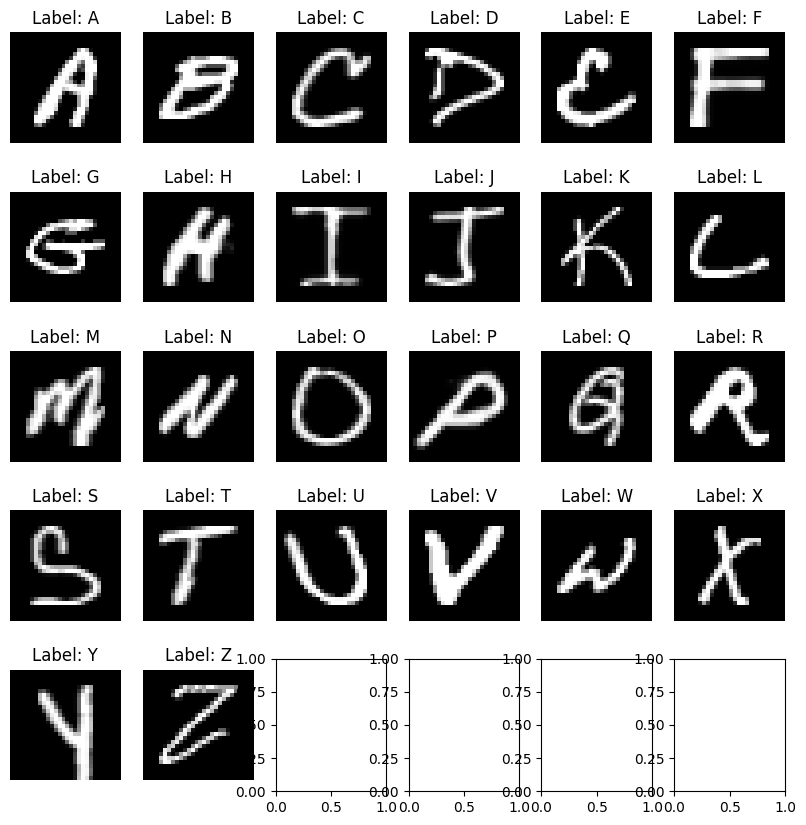

In [ ]:
fig, axes = plt.subplots(5, 6, figsize=(10, 10))

for i in range(numberOfDataClasses):
    classLabel = i
    currentImage = normalizedImages.loc[dataLabels == i].values[0].reshape(28,28)

    gridPosition = axes[i // 6, i % 6]
    gridPosition.imshow(currentImage, cmap='gray')
    gridPosition.set_title(f"Label: {chr(classLabel + 65)}")
    gridPosition.axis('off')

plt.show()


# Split the data into training and testing datasets

In [ ]:
imagesTraining, imagesTesting, labelsTraining, labelsTesting = train_test_split(normalizedImages, dataLabels, test_size=0.2, random_state=42, shuffle=True)



(imagesTraining.shape, imagesTesting.shape, labelsTraining.shape, labelsTesting.shape)

((297960, 784), (74490, 784), (297960,), (74490,))

# Split Training into Validation and Training

In [ ]:
imagesTrainingSubset, imagesValidationSubset, labelsTrainingSubset, labelsValidationSubset = train_test_split(
    imagesTraining, labelsTraining, test_size=0.2, random_state=42, shuffle=True
)

# **Third experiment (TensorFlow) - First neural network design:**

First Neural Network Design and its evaluation



In [ ]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='softplus'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='softplus'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(26, activation='softmax')
])

model.compile(optimizer= Adam(learning_rate=0.005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

snapshot = model.fit(imagesTrainingSubset, labelsTrainingSubset, epochs=12,validation_data=(imagesValidationSubset, labelsValidationSubset), batch_size = 64)


Epoch 1/12
3725/3725 [==============================] - 14s 4ms/step - loss: 0.4894 - accuracy: 0.8590 - val_loss: 0.2122 - val_accuracy: 0.9394
Epoch 2/12
3725/3725 [==============================] - 13s 3ms/step - loss: 0.3361 - accuracy: 0.9026 - val_loss: 0.1853 - val_accuracy: 0.9468
Epoch 3/12
3725/3725 [==============================] - 13s 3ms/step - loss: 0.3024 - accuracy: 0.9120 - val_loss: 0.1615 - val_accuracy: 0.9543
Epoch 4/12
3725/3725 [==============================] - 13s 4ms/step - loss: 0.2854 - accuracy: 0.9168 - val_loss: 0.1533 - val_accuracy: 0.9568
Epoch 5/12
3725/3725 [==============================] - 13s 4ms/step - loss: 0.2748 - accuracy: 0.9201 - val_loss: 0.1425 - val_accuracy: 0.9592
Epoch 6/12
3725/3725 [==============================] - 13s 3ms/step - loss: 0.2683 - accuracy: 0.9219 - val_loss: 0.1406 - val_accuracy: 0.9606
Epoch 7/12
3725/3725 [==============================] - 13s 4ms/step - loss: 0.2611 - accuracy: 0.9243 - val_loss: 0.1361 - val_ac

Accuracy and loss/error evaluation

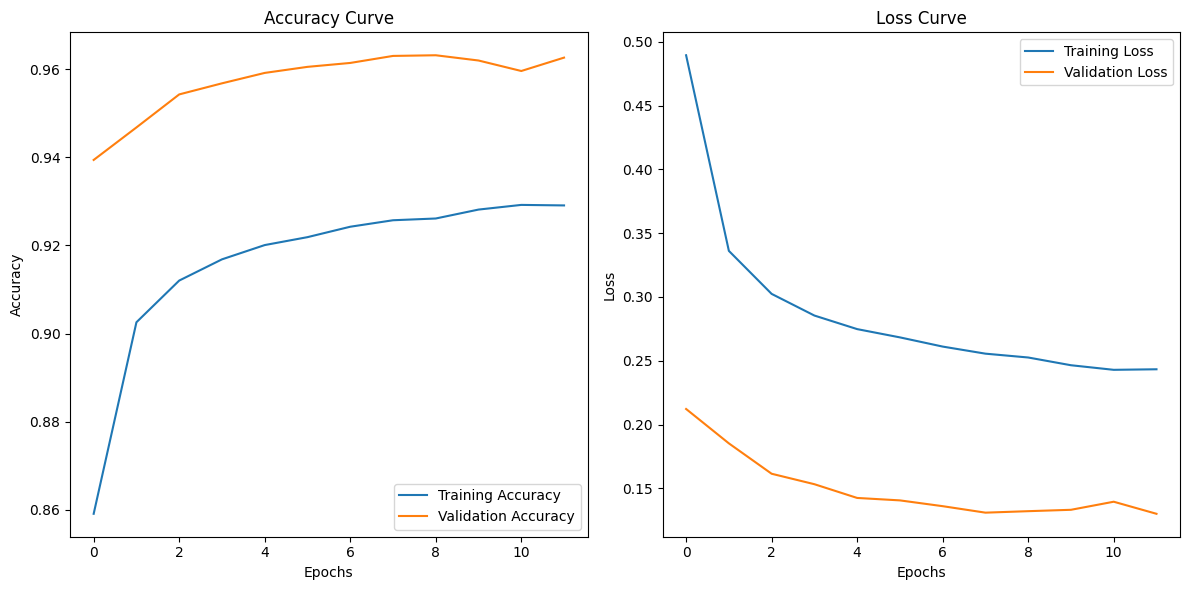

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(snapshot.history['accuracy'], label='Training Accuracy')
plt.plot(snapshot.history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(snapshot.history['loss'], label='Training Loss')
plt.plot(snapshot.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
totalPredicted = model.predict(imagesTesting)
predicted_labels = [np.argmax(i) for i in totalPredicted]
confusionMatrix = tf.math.confusion_matrix(labels=labelsTesting,predictions=predicted_labels)

f1 = f1_score(labelsTesting, predicted_labels, average='weighted')
print(f"Average F1 Score (Weighted): {f1:.4f}")

2328/2328 [==============================] - 4s 2ms/step
Average F1 Score (Weighted): 0.9626


# **Third experiment (TensorFlow) - Second neural network design:**

Second Neural Network Design and its evaluation

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(26, activation='softmax')
])

model.compile(optimizer= Adam(learning_rate=0.005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


snapshot = model.fit(imagesTrainingSubset, labelsTrainingSubset, epochs=12,
                     validation_data=(imagesValidationSubset, labelsValidationSubset),
                     batch_size=64,
                     shuffle=True)

Epoch 1/12
3725/3725 [==============================] - 22s 6ms/step - loss: 0.3266 - accuracy: 0.9041 - val_loss: 0.1542 - val_accuracy: 0.9558
Epoch 2/12
3725/3725 [==============================] - 20s 5ms/step - loss: 0.2024 - accuracy: 0.9405 - val_loss: 0.1215 - val_accuracy: 0.9641
Epoch 3/12
3725/3725 [==============================] - 21s 6ms/step - loss: 0.1707 - accuracy: 0.9494 - val_loss: 0.1005 - val_accuracy: 0.9704
Epoch 4/12
3725/3725 [==============================] - 20s 5ms/step - loss: 0.1523 - accuracy: 0.9549 - val_loss: 0.0922 - val_accuracy: 0.9737
Epoch 5/12
3725/3725 [==============================] - 20s 5ms/step - loss: 0.1406 - accuracy: 0.9580 - val_loss: 0.0884 - val_accuracy: 0.9743
Epoch 6/12
3725/3725 [==============================] - 20s 5ms/step - loss: 0.1296 - accuracy: 0.9617 - val_loss: 0.0790 - val_accuracy: 0.9776
Epoch 7/12
3725/3725 [==============================] - 20s 5ms/step - loss: 0.1214 - accuracy: 0.9638 - val_loss: 0.0740 - val_ac

Save the best model

In [ ]:
model.save('bestModel.keras')

model = tf.keras.models.load_model('bestModel.keras')

Accuracy and loss/error evaluation

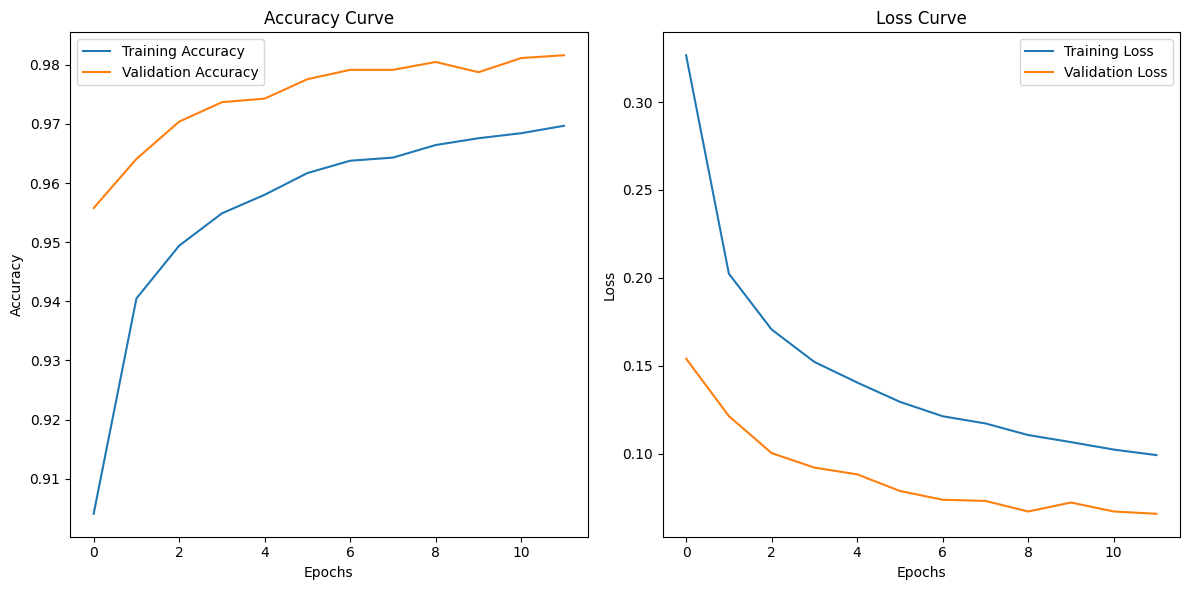

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(snapshot.history['accuracy'], label='Training Accuracy')
plt.plot(snapshot.history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(snapshot.history['loss'], label='Training Loss')
plt.plot(snapshot.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion matrix

2328/2328 [==============================] - 4s 2ms/step


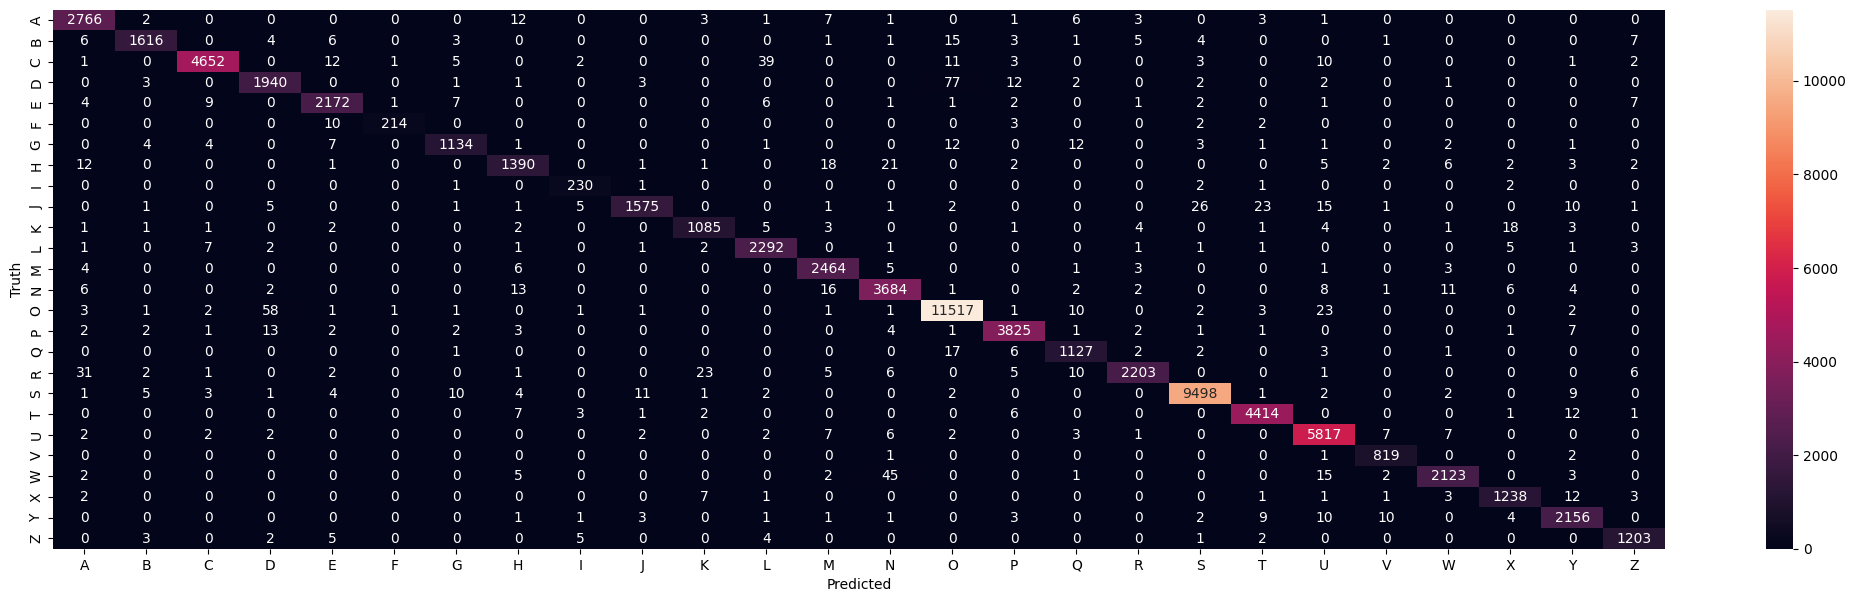

In [ ]:
totalPredicted = model.predict(imagesTesting)
predicted_labels = [np.argmax(i) for i in totalPredicted]
confusionMatrix = tf.math.confusion_matrix(labels=labelsTesting,predictions=predicted_labels)

class_names = [chr(i) for i in range(65, 91)]

plt.figure(figsize=(26, 7))
sns.heatmap(confusionMatrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Average f-1 scores

In [ ]:
f1 = f1_score(labelsTesting, predicted_labels, average='weighted')
print(f"Average F1 Score (Weighted): {f1:.4f}")

Average F1 Score (Weighted): 0.9820


# Test with team names alphabets

1/1 [==============================] - 0s 22ms/step


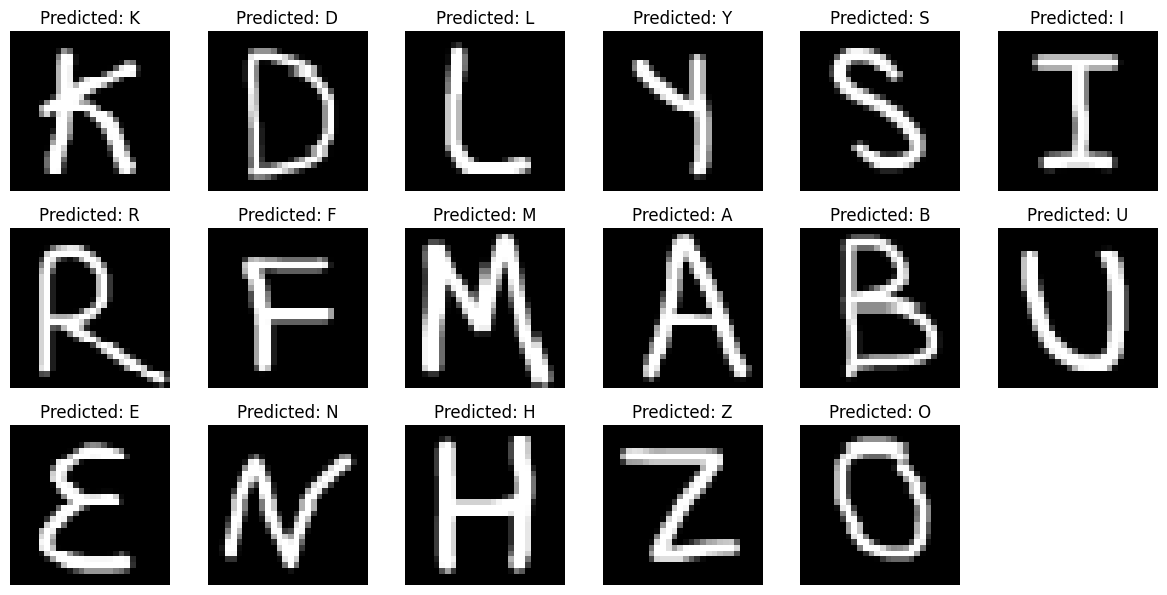

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

folder_path = "Alphabets"
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

rows, cols = 5, 6
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))

for idx, img_file in enumerate(image_files):
    if idx >= rows * cols:
        break

    img_path = os.path.join(folder_path, img_file)
    img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img).astype('float32') / 255.0
    img_array = img_array.flatten().reshape(1, -1)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=-1)[0]

    grid_position = axes[idx // cols, idx % cols]
    grid_position.imshow(img, cmap='gray')
    grid_position.set_title(f'Predicted: {chr(predicted_class + 65)}')
    grid_position.axis('off')

for j in range(idx + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()